# end to end model execution

怎么样将机器学习模型的张量函数整合到计算图中

将使用一真实的模型

In [1]:
from __future__ import annotations
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T
from tvm.script import relax as R
import numpy as np
from tvm import relax
# This is needed for deferring annotation parsing in TVMScript


## load dataset
fashion MNIST dataset.

In [5]:
import torchvision
import torch
test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
               
img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

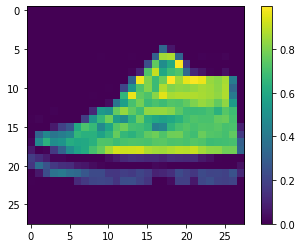

Class: Sneaker


In [6]:
import matplotlib.pyplot as plt

plt.figure() 
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

## load model parameter

In [7]:
!wget https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2022-07-11 15:28:06--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
正在解析主机 github.com (github.com)... 20.205.243.166
正在连接 github.com (github.com)|20.205.243.166|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 302 Found
位置：https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [跟随至新的 URL]
--2022-07-11 15:28:06--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
正在解析主机 raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
正在连接 raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度： 407396 (398K) [application/octet-stream]
正在保存至: “fasionmnist_mlp_params.pkl.1”

fasionmnist_mlp_par 100%[===================>] 397.85K  1.15MB/s    用时 0.3s    

2022-07-11 15:28:08 (1.15 MB/s) - 已保存 “fasionmnist_mlp_params.pkl.1” [407396/407396])



## 端到端模型整合
两层神经网络(这里省略了 softmax)
- linear -> relu -> linear

In [8]:
# numpy 实现
def numpy_mlp(data, w0, b0, w1, b1):
    """_summary_

    Args:
        data (np.ndarray): data shape: (batch size, input size)
        w0 (np.ndarray): data shape: (input size, hidden size)
        b0 (np.ndarray): data shape: (hidden size, )
        w1 (np.ndarray): data shape: (hidden size, class num)
        b1 (np.ndarray): data shape: (class num)
    """
    lv0 = data @ w0.T + b0
    lv1 = np.maximum(lv0, 0)
    lv2 = lv1 @ w1.T + b1
    return lv2

In [9]:
import pickle as pkl
mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
res = numpy_mlp(
    data = img.reshape(1, 784),
    w0 = mlp_params["w0"],
    b0 = mlp_params["b0"],
    w1 = mlp_params["w1"],
    b1 = mlp_params["b1"]
)

print(res)
pred_kind = res.argmax(axis=1)
print(pred_kind)
print("Numpy-MLP Prediction:", class_names[pred_kind[0]])

[[-16.835085  -31.70045   -21.136889  -24.41916   -30.072502   -3.3631787
  -24.313276   19.233906  -13.347248   -5.056448 ]]
[7]
Numpy-MLP Prediction: Sneaker


## low level numpy 实现

In [10]:
def lnumpy_linear0(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    """_summary_

    Args:
        X (np.ndarray): shape (1, 784)
        W (np.ndarray): shape (784, 128)
        B (np.ndarray): shape (128, )
        Z (np.ndarray): (1, 128))
    """
    Y = np.empty((1, 128), dtype="float32")
    for i in range(1):
        for j in range(128):
            for k in range(784):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]
    
    for i in range(1):
        for j in range(128):
            Z[i, j] = Y[i, j] + B[j]

def lnumpy_relu0(X: np.ndarray, Y: np.ndarray):
    """_summary_

    Args:
        X (np.ndarray): shape (1, 128)
        Y (np.ndarray): shape (1, 128)
    """
    for i in range(1):
        for j in range(128):
            Y[i, j] = np.maximum(X[i, j], 0)

def lnumpy_linear1(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    """_summary_

    Args:
        X (np.ndarray): shape (1, 128)
        W (np.ndarray): shape (128, 10)
        B (np.ndarray): shape (10, )
        Z (np.ndarray): (1, 10))
    """
    Y = np.empty((1, 10), dtype="float32") 
    for i in range(1):
        for j in range(10):
            for k in range(128):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]

    for i in range(1):
        for j in range(10):
            Z[i, j] = Y[i, j] + B[j]

# main
def lnumpy_mlp(X: np.ndarray,
               w0: np.ndarray,
               b0: np.ndarray,
               w1: np.ndarray,
               b1: np.ndarray):
    """_summary_

    Args:
        X (np.ndarray): shape (1, 784)
        w0 (np.ndarray): shape (784, 128)
        b0 (np.ndarray): shape (128, )
        w1 (np.ndarray): shape (128, 10)
        b1 (np.ndarray): shape (10, )
    """
    # 中间结果 lv0
    lv0 = np.empty((1, 128), dtype="float32")
    lnumpy_linear0(X, w0, b0, lv0)
    # 中间结果 lv1
    lv1 = np.empty((1, 128), dtype="float32")
    lnumpy_relu0(lv0, lv1)

    out = np.empty((1, 10), dtype="float32")
    lnumpy_linear1(lv1, w1, b1, out)
    return out

result = lnumpy_mlp(img.reshape(1, 784),
                    mlp_params["w0"],
                    mlp_params["b0"],
                    mlp_params["w1"],
                    mlp_params["b1"])
print(result)
pred_kind = result.argmax(axis=1)
print("Low-level Numpy MLP Prediction:", class_names[pred_kind[0]])

[[-16.835081  -31.700447  -21.136889  -24.419159  -30.072495   -3.3631804
  -24.31327    19.233908  -13.347247   -5.056448 ]]
Low-level Numpy MLP Prediction: Sneaker


## Construct end to end in TVMScript

In [25]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"],
                W0: T.Buffer[(128, 784),"float32"],
                B0: T.Buffer[(128, ), "float32"],
                Z: T.Buffer[(1, 128), "float32"]):

        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = 0
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W0[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B0[vj] 

    @T.prim_func
    def relu0(X: T.Buffer[(1, 128), "float32"],
              Y: T.Buffer[(1, 128), "float32"]):

        T.func_attr({"global_symbol": "relu0", "tir.noalias": True})
        for i, j in T.grid(1, 128):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))
    
    @T.prim_func
    def linear1(X: T.Buffer[(1, 128), "float32"], 
                W: T.Buffer[(10, 128), "float32"], 
                B: T.Buffer[(10, ), "float32"], 
                Z: T.Buffer[(1, 10), "float32"]):
                
        T.func_attr({"global_symbol": "linear1", "tir.noalias": True})
        Y = T.alloc_buffer((1, 10), "float32")
        for i, j, k in T.grid(1, 10, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
    
        for i, j in T.grid(1, 10):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]
    
    @R.function
    def main(x: Tensor((1, 784), "float32"), 
             w0: Tensor((128, 784), "float32"), 
             b0: Tensor((128, ), "float32"), 
             w1: Tensor((10, 128), "float32"), 
             b1: Tensor((10, ), "float32")):
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir(relu0, (lv0), (1, 128), dtype="float32")
            out = R.call_tir(linear1, (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out

注意这里每一个张量函数都需要将输出都当做函数的参数传入，但是我们在上层的计算图中希望张量函数通过返回值的方式返回

因此 tvm 这里提出目标传递 (destination passing) 的概念。这个想法是输入和输出在外部显式分配并传递给底层元函数。 这种风格通常用于底层库设计，因此高层框架可以处理内存分配决策。 请注意，并非所有张量操作都可以通过这种方式呈现（比如，有些操作的输出形状取决于输入）。 然而，在通常的实践中，如果可能的话，以这种风格编写底层函数通常是有帮助的。

虽然可以通过显式分配中间结果并调用每个函数来将目标传递的函数组装在一起，但很难将以下代码转换为计算图形式。

下面为 `call_tir` 的一种实现，在实际应用中，可以有不同的底层方法来优化执行。 例如，我们可能会选择提前分配所有输出内存，然后运行，我们将在以后的课程中介绍。

In [26]:
def lnumpy_call_tir(prim_func, inputs, out_shape, dtype):
    res = np.empty(out_shape, dtype=dtype)
    prim_func(*inputs, res)
    return res

我们还可以在底层 NumPy 中看到 `call_tir` 的作用。 现在我们已经定义了 `lnumpy_call_tir`，我们可以将底层 NumPy 代码重写为：

In [27]:
def lnumpy_mlp(data, w0, b0, w1, b1):
    lv0 = lnumpy_call_tir(lnumpy_linear0, (data, w0, b0), (1, 128), dtype="float32")
    lv1 = lnumpy_call_tir(lnumpy_relu0, (lv0, ), (1, 128), dtype="float32")
    out = lnumpy_call_tir(lnumpy_linear1, (lv1, w1, b1), (1, 10), dtype="float32")
    return out

res = lnumpy_mlp(img.reshape(1, -1),
                 w0=mlp_params["w0"],
                 b0=mlp_params["b0"],
                 w1=mlp_params["w1"],
                 b1=mlp_params["b1"])
print("Low-level Numpy with CallTIR Prediction:", class_names[pred_kind[0]])

Low-level Numpy with CallTIR Prediction: Sneaker


Dataflow block

## 构建并运行

##

In [28]:
print(MyModule.script())

@tvm.script.ir_module
class Module:
    @tir.prim_func
    def linear0(X: tir.Buffer[(1, 784), "float32"], W0: tir.Buffer[(128, 784), "float32"], B0: tir.Buffer[128, "float32"], Z: tir.Buffer[(1, 128), "float32"]) -> None:
        # function attr dict
        tir.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        # body
        # with tir.block("root")
        Y = tir.alloc_buffer([1, 128], dtype="float32")
        for i, j, k in tir.grid(1, 128, 784):
            with tir.block("Y"):
                vi, vj, vk = tir.axis.remap("SSR", [i, j, k])
                tir.reads(X[vi, vk], W0[vj, vk])
                tir.writes(Y[vi, vj])
                with tir.init():
                    Y[vi, vj] = 0
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W0[vj, vk]
        for i, j in tir.grid(1, 128):
            with tir.block("Z"):
                vi, vj = tir.axis.remap("SS", [i, j])
                tir.reads(Y[vi, vj], B0[vj])
                tir.writes(Z[vi, vj])
     

In [29]:
ex = relax.vm.build(MyModule, target="llvm")
type(ex)

tvm.relax.vm.Executable

build 函数会给我们一个可执行文件（译者注：“可执行文件”并非传统操作系统中的可执行文件，不能直接在系统中运行，而是针对Relax VM设计的一种文件格式）。 我们可以初始化一个虚拟机执行器，使我们能够运行该函数。 此外，我们将传入第二个参数，指示我们要在哪个设备上运行端到端执行。

In [30]:
vm = relax.VirtualMachine(ex, tvm.cpu())

现在我们准备好运行模型了。 我们首先构建包含输入数据和权重的 tvm NDArray。

In [31]:
data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

In [32]:
nd_res = vm["main"](data_nd, nd_params["w0"], nd_params["b0"], nd_params["w1"], nd_params["b1"])
print(nd_res)

[[-16.835081  -31.700447  -21.136889  -24.419159  -30.072495   -3.3631804
  -24.31327    19.233908  -13.347247   -5.056448 ]]


## 在环境中集成现有的库
在许多情况下，我们可能希望将现有的库函数集成到 MLC 过程中。

下面的 IRModule 展示了如何做到这一点：

这些字符串是我们期望在模型执行期间的运行时函数 (runtime function) 的名称。

In [33]:
@tvm.script.ir_module
class MyModuleWithExternCall:
    @R.function
    def main(x: Tensor((1, 784), "float32"),
             w0: Tensor((128, 784), "float32"),
             b0: Tensor((128,), "float32"),
             w1: Tensor((10, 128), "float32"),
             b1: Tensor((10,), "float32")):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir("env.linear", (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir("env.relu", (lv0,), (1, 128), dtype="float32")
            out = R.call_tir("env.linear", (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out

下面实现 env.linear

注意：
- 在上面的代码中，我们使用 from_dlpack 将 TVM NDArray 转换为 torch NDArray。 请注意，这是一个零拷贝转换，这意味着 Torch 阵列与 TVM NDArray 共享底层内存。
- DLPack 是一种通用的交换标准，允许不同的框架交换 Tensor/NDArray 而无需参与数据复制。 from_dlpack API 由多个框架支持，是 Python 数组 API 标准的一部分。

在这个特定的函数中，我们只是简单地调用 PyTorch 的实现。 在真实的应用场景中，我们可以使用类似的机制将调用重定向到特定的库，例如 cuDNN 或我们自己的库实现。

In [46]:

@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)

    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.relu", override=True)
def torch_relu(x: tvm.nd.NDArray, out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.max(x_torch, torch.Tensor([0.0]), out=out_torch)

### Build and run

In [47]:
ex = relax.vm.build(MyModuleWithExternCall, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())
nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithExternCall Prediction:", class_names[pred_kind[0]])

MyModuleWithExternCall Prediction: Sneaker


## Mixing TensorIR Code and Libraries

在上一个示例中，我们构建了一个 IRModule，其中所有元操作都被分派给运行库。有时将两者混合使用会有所帮助。

In [48]:
@tvm.script.ir_module
class MyModuleMixture:
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"],
                W: T.Buffer[(128, 784), "float32"],
                B: T.Buffer[(128,), "float32"],
                Z: T.Buffer[(1, 128), "float32"]):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @R.function
    def main(x: Tensor((1, 784), "float32"),
             w0: Tensor((128, 784), "float32"),
             b0: Tensor((128,), "float32"),
             w1: Tensor((10, 128), "float32"),
             b1: Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir("env.relu", (lv0,), (1, 128), dtype="float32")
            out = R.call_tir("env.linear", (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out

上面的代码块显示了一个示例，其中 linear0 仍然在 TensorIR 中实现，而其余函数被重定向到库函数。 我们可以构建并运行以验证结果。

In [49]:
ex = relax.vm.build(MyModuleMixture, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleMixture Prediction:", class_names[pred_kind[0]])

MyModuleMixture Prediction: Sneaker


## 将参数绑定到 IRModule
在到目前为止的所有示例中，我们通过显式传递参数来构造主函数。 在许多情况下，将参数绑定为附加到 IRModule 的常量通常会降低API的复杂程度。 以下代码通过将参数名称与 nd_params 中的键匹配来创建绑定。

In [55]:
print(MyModuleMixture.script())
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)
print("------------------------------------")
print(MyModuleWithParams.script())

@tvm.script.ir_module
class Module:
    @relax.function
    def main(x: Tensor((1, 784), "float32"), w0: Tensor((128, 784), "float32"), b0: Tensor((128,), "float32"), w1: Tensor((10, 128), "float32"), b1: Tensor((10,), "float32")) -> Tensor(None, "float32", ndim = 2):
        # block 0
        with relax.dataflow():
            lv0 = relax.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
            lv1 = relax.call_tir("env.relu", (lv0,), (1, 128), dtype="float32")
            out = relax.call_tir("env.linear", (lv1, w1, b1), (1, 10), dtype="float32")
            relax.output(out)
        return out
    
    @tir.prim_func
    def linear0(X: tir.Buffer[(1, 784), "float32"], W: tir.Buffer[(128, 784), "float32"], B: tir.Buffer[128, "float32"], Z: tir.Buffer[(1, 128), "float32"]) -> None:
        # function attr dict
        tir.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        # body
        # with tir.block("root")
        Y = tir.alloc_buffer([1, 128], dtyp

在上面的脚本中，`meta[relay.Constant][0]` （译者注：目前 Relax 的常量表达依然继承自 Relay ，未来改API可能会更改） 对应于一个存储常量的隐式字典（它没有显示为脚本的一部分，但仍然是 IRModule 的一部分）。 如果我们构建转换后的 IRModule，我们现在可以通过传入输入数据来调用该函数。

In [56]:
ex = relax.vm.build(MyModuleWithParams, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])

MyModuleWithParams Prediction: Sneaker
